In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

## Loading data into tf Dataset

In [20]:
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMG_SIZE, IMG_SIZE),  
    batch_size = BATCH_SIZE

)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
# No of batches
len(dataset)

68

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 1 1]


## Data Visualization

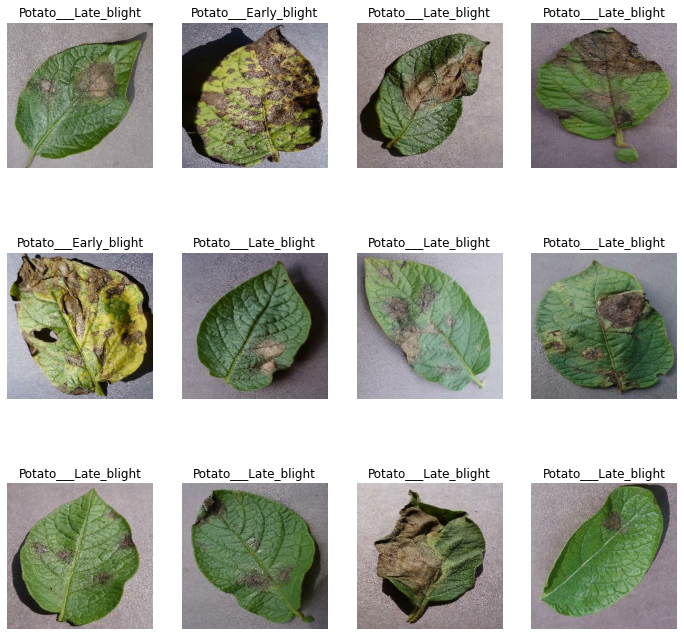

In [8]:
plt.figure(figsize=(12,12))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i].numpy()])
        plt.axis("off")

## Train Test Split

In [9]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

In [21]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

## Compiling the Model

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 137s 2s/step - loss: 0.9030 - accuracy: 0.4931 - val_loss: 0.8811 - val_accuracy: 0.5833
Epoch 2/50
54/54 [==============================] - 112s 2s/step - loss: 0.7423 - accuracy: 0.6777 - val_loss: 0.6587 - val_accuracy: 0.7135
Epoch 3/50
54/54 [==============================] - 115s 2s/step - loss: 0.4437 - accuracy: 0.8015 - val_loss: 0.5385 - val_accuracy: 0.7604
Epoch 4/50
54/54 [==============================] - 112s 2s/step - loss: 0.3467 - accuracy: 0.8646 - val_loss: 0.3876 - val_accuracy: 0.8490
Epoch 5/50
54/54 [==============================] - 113s 2s/step - loss: 0.2554 - accuracy: 0.9022 - val_loss: 0.2976 - val_accuracy: 0.8854
Epoch 6/50
54/54 [==============================] - 109s 2s/step - loss: 0.2546 - accuracy: 0.9005 - val_loss: 0.1502 - val_accuracy: 0.9271
Epoch 7/50
54/54 [==============================] - 104s 2s/step - loss: 0.2033 - accuracy: 0.9138 - val_loss: 0.3155 - val_accuracy: 0.8698
Epoch 8/50
54

In [25]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 8s 466ms/step - loss: 0.1246 - accuracy: 0.9570


In [26]:
scores

[0.12464077025651932, 0.95703125]

## Plotting the Accuracy and Loss Curves

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
history.history['loss']

[0.9029895663261414,
 0.7423324584960938,
 0.44365236163139343,
 0.3467426002025604,
 0.25542107224464417,
 0.25462496280670166,
 0.20332567393779755,
 0.19207242131233215,
 0.16610263288021088,
 0.16254428029060364,
 0.1334102898836136,
 0.09942102432250977,
 0.18770430982112885,
 0.13044670224189758,
 0.11945537477731705,
 0.10602664947509766,
 0.06834744662046432,
 0.1083056777715683,
 0.08544640988111496,
 0.05827636644244194,
 0.04573828727006912,
 0.07897085696458817,
 0.04479089751839638,
 0.033721115440130234,
 0.059260301291942596,
 0.0647566169500351,
 0.05368240177631378,
 0.03727871924638748,
 0.03766939043998718,
 0.05875773727893829,
 0.07820499688386917,
 0.042793434113264084,
 0.033953696489334106,
 0.05096206068992615,
 0.031190644949674606,
 0.050276271998882294,
 0.07540681958198547,
 0.02969285659492016,
 0.029651105403900146,
 0.015550089068710804,
 0.022129880264401436,
 0.024366023018956184,
 0.016628380864858627,
 0.022539248690009117,
 0.06099596247076988,
 0.0

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

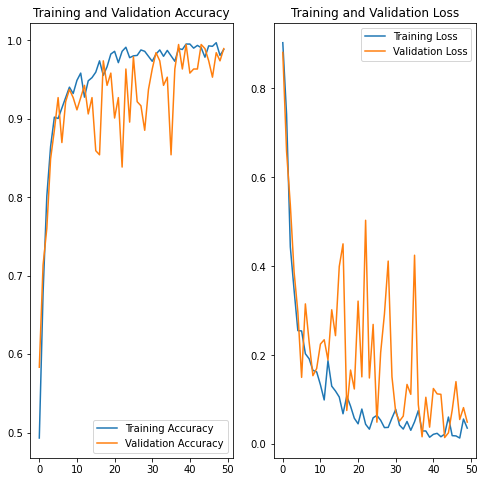

In [32]:
EPOCHS = 50
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 2s 2s/step
[[9.99601066e-01 3.98981647e-04 1.77272970e-08]
 [5.80686765e-06 9.99803245e-01 1.90917068e-04]
 [1.85039462e-04 9.99802291e-01 1.26785153e-05]
 [1.48350329e-04 9.99850392e-01 1.18304285e-06]
 [9.99999523e-01 4.52167825e-07 8.30294253e-17]
 [7.99845878e-08 3.17789527e-04 9.99682188e-01]
 [9.99998808e-01 1.22680819e-06 2.49190274e-15]
 [9.99998569e-01 1.43914929e-06 9.36420546e-16]
 [1.00000000e+00 1.54624868e-10 1.20793611e-19]
 [2.13267491e-03 9.97860730e-01 6.59174293e-06]
 [9.99998927e-01 1.02586512e-06 7.25432152e-14]
 [1.00000000e+00 1.15072485e-08 1.51421466e-17]
 [1.93380165e-05 9.99980688e-01 3.79589089e-08]
 [1.00000000e+00 2.45573784e-09 4.19962408e-20]
 [6.26085609e-13 7.95163851e-06 9.99992013e-01]
 [2.87986768e-06 9.98409092e-01 1.58807170e-03]
 [1.00000000e+00 4.94870811e-08 2.71131121e-12]
 [1.00000000e+00 1.90358236e-08 5.30860488e-18]
 [6.49733352e-04 9.99343812

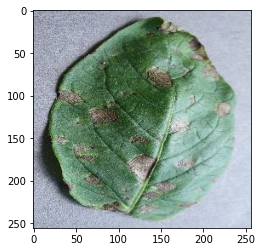

In [33]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 39ms/step


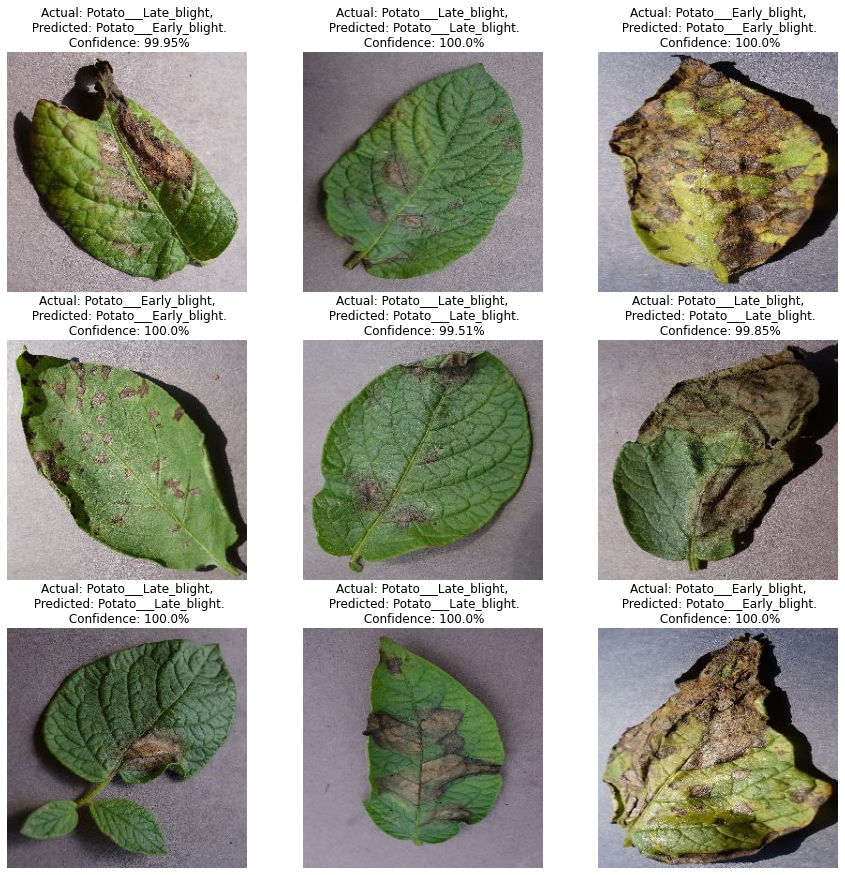

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")